<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fits" data-toc-modified-id="Fits-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fits</a></span></li><li><span><a href="#Análise-ntc(10,0)-com-defeito" data-toc-modified-id="Análise-ntc(10,0)-com-defeito-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Análise ntc(10,0) com defeito</a></span></li><li><span><a href="#Dependência-dos-splits-e-nível-de-impureza" data-toc-modified-id="Dependência-dos-splits-e-nível-de-impureza-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dependência dos splits e nível de impureza</a></span></li><li><span><a href="#Estudos-de-espectro-de-absorção" data-toc-modified-id="Estudos-de-espectro-de-absorção-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Estudos de espectro de absorção</a></span></li></ul></div>

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
from scipy.optimize import curve_fit
import sys
import os
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget


plt.rc('lines', linewidth=2.0, markersize=10.0)
plt.rc('text', usetex=True)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10, 7))
plt.rc('figure', autolayout=True)

In [2]:
def Get_dispersao_TB(file_disp):
    
    arq_band = open(file_disp)

    Kpath = []
    E = []
    
    for line in arq_band:
        linha = line.split()
        if len(linha) == 0:
            Kpath.append([])
            E.append([])
        if len(linha) == 2:
            Kpath[-1].append(float(linha[0]))
            E[-1].append(float(linha[1]))
            
    arq_band.close()
    
    # Normalizando o caminho
    
    maxK = max(Kpath[0])
    for i in range(len(Kpath)):
        for j in range(len(Kpath[i])):
            Kpath[i][j] = Kpath[i][j]/maxK
    
                
    return Kpath, E

def Get_dispersao_QE(file_disp, banda_nivel_0, Klim_red):
    
    arq_band = open(file_disp)

    Kpath = [[]]
    E = [[]]
    
    for line in arq_band:
        linha = line.split()
        if len(linha) == 0:
            Kpath.append([])
            E.append([])
        if len(linha) == 2:
            Kpath[-1].append(float(linha[0]))
            E[-1].append(float(linha[1]))
            
    arq_band.close()
    
    Efermi = E[banda_nivel_0-1][0]
    
    for i in range(len(E)):
        for j in range(len(E[i])):
            E[i][j] = E[i][j] - Efermi
    
    # Normalizando o caminho
    Kcorte_ind = 0
    
    maxK = max(Kpath[0])
    for i in range(len(Kpath)):
        for j in range(len(Kpath[i])):
            Kpath[i][j] = Kpath[i][j]/maxK
            if Kpath[i][j] <= Klim_red:
                Kcorte_ind = j
        Kpath[i] = Kpath[i][0:Kcorte_ind+1]
        E[i] = E[i][0:Kcorte_ind+1]
        
    maxK = max(Kpath[0])
    for i in range(len(Kpath)):
        for j in range(len(Kpath[i])):
            Kpath[i][j] = Kpath[i][j]/maxK
                
    return Kpath, E

def get_disp_BGW(file, banda_nivel_0):

    arq = open(file)
    K, Emf_k, Eqp_k, ind_bandas = [], [], [], []

    for line in arq:
        linha = line.split()
        if len(linha) == 8:
            if float(linha[4]) >= 0:
                if ind_bandas.count(int(linha[1])) == 0:
                    ind_bandas.append(int(linha[1]))
                    K.append([float(linha[4])])
                    Emf_k.append([float(linha[5])])
                    Eqp_k.append([float(linha[6])])
                else:
                    ind = ind_bandas.index(int(linha[1]))
                    K[ind].append(float(linha[4]))
                    Emf_k[ind].append(float(linha[5]))
                    Eqp_k[ind].append(float(linha[6]))
                
    indE0 = ind_bandas.index(banda_nivel_0)
    E0mf, E0qp = Emf_k[indE0][0], Eqp_k[indE0][0]
    Kmax = max(K[0])

    for i in range(len(K)):
        for j in range(len(K[i])):
            Emf_k[i][j] = Emf_k[i][j] - E0mf
            Eqp_k[i][j] = Eqp_k[i][j] - E0qp
            K[i][j] = K[i][j]/Kmax

    return K, Emf_k, Eqp_k

# Fits



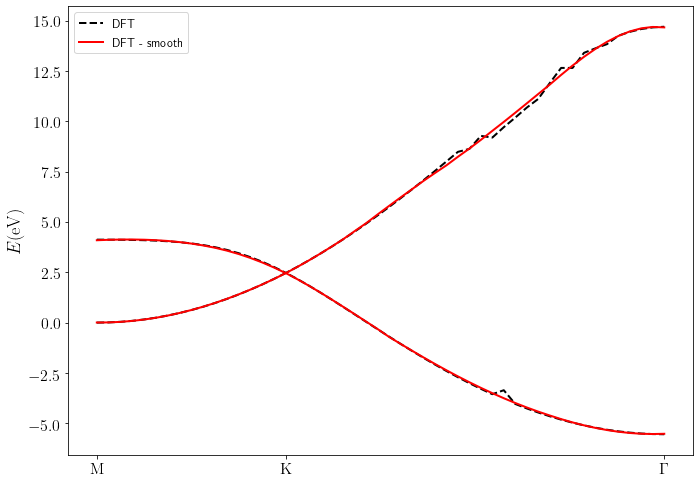

In [3]:
# Deixando dispersao DFT smooth devido ao cruzamento de bandas

arqDTF = 'dispersao_grafeno_DFT/Dispersao_ref.out'

Kpath_graf_DFT, E_graf_DFT = Get_dispersao_TB(arqDTF)


plt.figure()

for i in range(len(Kpath_graf_DFT)):
    plt.plot(Kpath_graf_DFT[i], E_graf_DFT[i], 'k--', linewidth=2.0)

E_graf_DFT2 = [[], []]
for i in range(len(Kpath_graf_DFT[0])):
    if Kpath_graf_DFT[0][i] < 1/3.0:
        E_graf_DFT2[0].append(E_graf_DFT[0][i])
        E_graf_DFT2[1].append(E_graf_DFT[1][i])
    else:
        E_graf_DFT2[0].append(E_graf_DFT[1][i])
        E_graf_DFT2[1].append(E_graf_DFT[0][i])


plt.ylabel(r'$E(\mathrm{eV})$')
plt.xticks([0.0, 1/3.0, 1], [r'$\mathrm{M}$', r'$\mathrm{K}$', r'$\Gamma$'])


from scipy.signal import savgol_filter
yhat = savgol_filter(E_graf_DFT2[0], 21, 3) # window size 51, polynomial order 3
plt.plot(Kpath_graf_DFT[0], yhat, 'r')

yhat = savgol_filter(E_graf_DFT2[1], 21, 3) # window size 21, polynomial order 3
plt.plot(Kpath_graf_DFT[0], yhat, 'r')

plt.plot([0], [0], 'k--', label='DFT')
plt.plot([0], [0], 'r-', label='DFT - smooth')
plt.legend(fontsize=12)


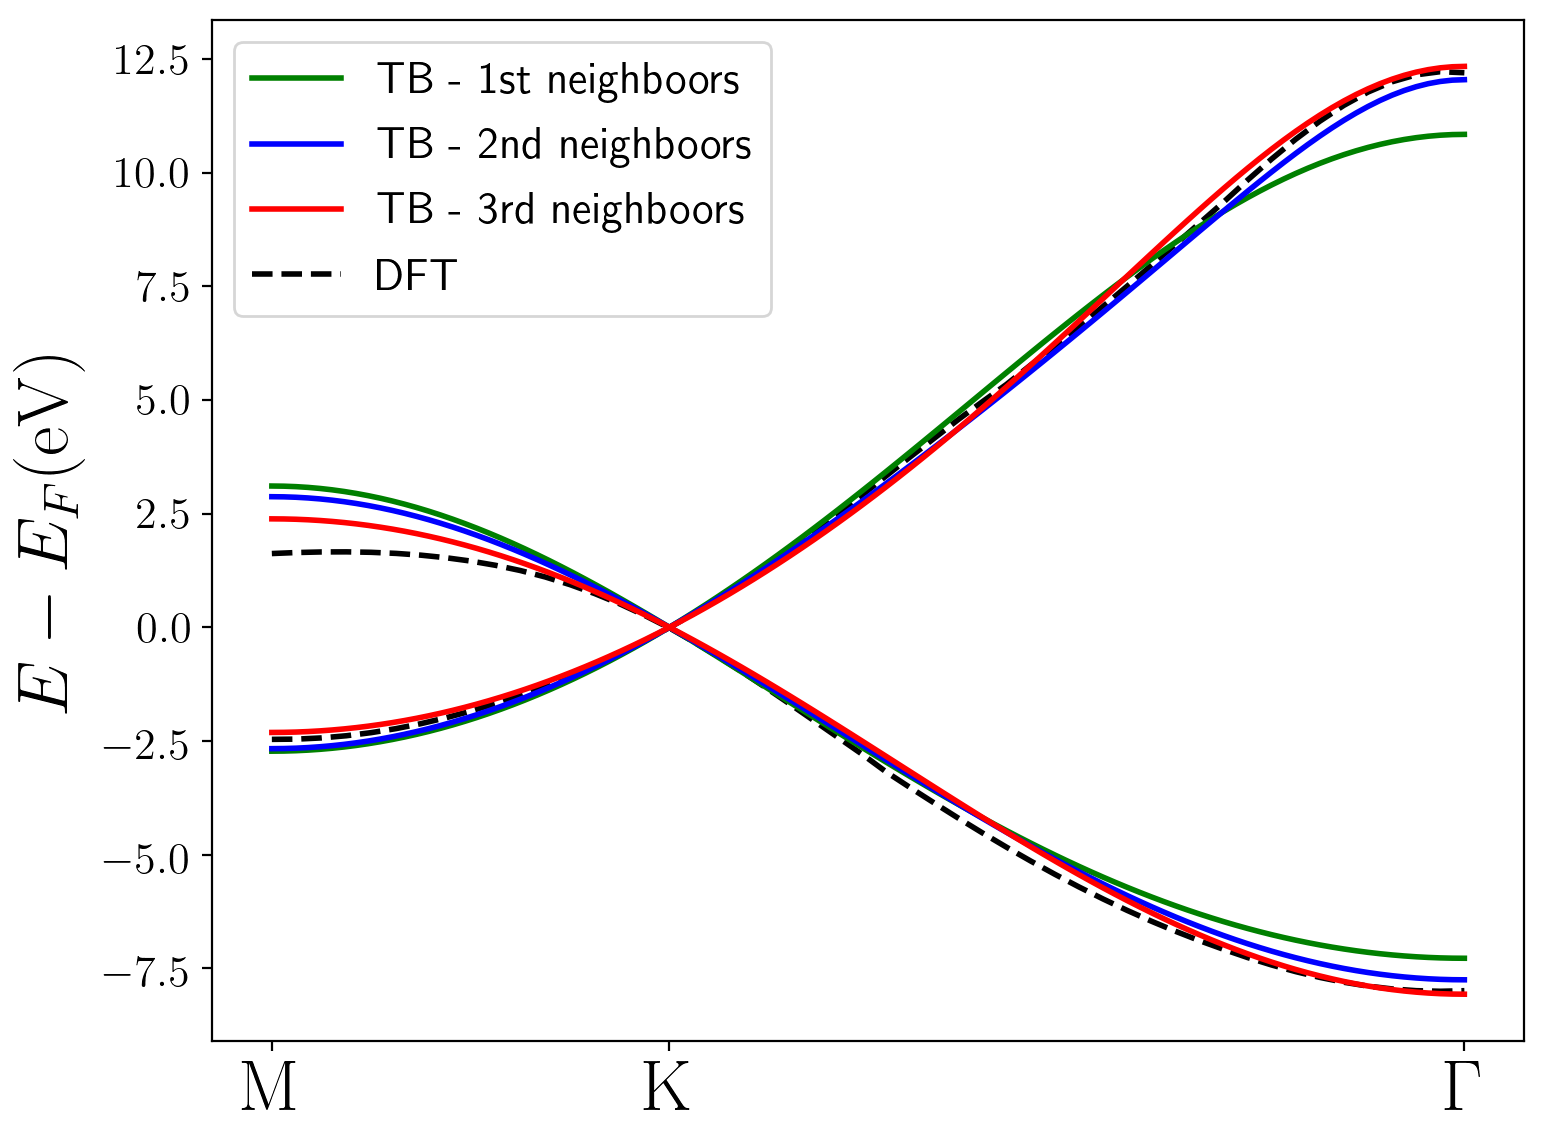

In [4]:
plt.figure(figsize=(8,6), dpi=200)

Efermi = E_graf_DFT2[0][Kpath_graf_DFT[0].index(0.3333)]

yhat = savgol_filter(E_graf_DFT2[0], 21, 3) # window size 51, polynomial order 3
plt.plot(Kpath_graf_DFT[0], yhat - Efermi, 'k--')

yhat = savgol_filter(E_graf_DFT2[1], 21, 3) # window size 21, polynomial order 3
plt.plot(Kpath_graf_DFT[0], yhat - Efermi, 'k--')


arq1viz = 'Dispersoes/Dispersao_grafeno_1viz.out'
arq2viz = 'Dispersoes/Dispersao_grafeno_2viz.out'
arq3viz = 'Dispersoes/Dispersao_grafeno_3viz.out'

Kpath_graf_1viz, E_graf_1viz = Get_dispersao_TB(arq1viz)
Kpath_graf_2viz, E_graf_2viz = Get_dispersao_TB(arq2viz)
Kpath_graf_3viz, E_graf_3viz = Get_dispersao_TB(arq3viz)

for i in range(len(Kpath_graf_1viz)):
    new_list = list(abs(np.array(Kpath_graf_1viz[i]) - 1/3))
    min_index = new_list.index(min(new_list))
    Efermi = E_graf_1viz[i][min_index]
    plt.plot(Kpath_graf_1viz[i], np.array(E_graf_1viz[i]) - Efermi, 'g-', linewidth=2.0)

for i in range(len(Kpath_graf_2viz)):
    new_list = list(abs(np.array(Kpath_graf_2viz[i]) - 1/3))
    min_index = new_list.index(min(new_list))
    Efermi = E_graf_2viz[i][min_index]
    plt.plot(Kpath_graf_2viz[i], np.array(E_graf_2viz[i]) - Efermi, 'b-', linewidth=2.0)
    
for i in range(len(Kpath_graf_3viz)):
    new_list = list(abs(np.array(Kpath_graf_3viz[i]) - 1/3))
    min_index = new_list.index(min(new_list))
    Efermi = E_graf_3viz[i][min_index]
    plt.plot(Kpath_graf_3viz[i], np.array(E_graf_3viz[i])- Efermi, 'r-', linewidth=2.0)


plt.ylabel(r'$E - E_F (\mathrm{eV})$', fontsize=26)
plt.xticks([0.0, 1/3.0, 1], [r'$\mathrm{M}$', r'$\mathrm{K}$', r'$\Gamma$'], fontsize=26)

plt.plot([0], [0], 'g-', label='TB - 1st neighboors')
plt.plot([0], [0], 'b-', label='TB - 2nd neighboors')
plt.plot([0], [0], 'r-', label='TB - 3rd neighboors')
plt.plot([0], [0], 'k--', label='DFT')
plt.legend(fontsize=16)


In [6]:
Kpath_ntc_8_0_QP_ref, E_ntc_8_0_DFT_temp, E_ntc_8_0_QP_ref = get_disp_BGW('/HD/Dropbox/Research/Excitons_CNTs/cnt_8_0/pure/GWbse_ptsK_24co_192fi/8-absorption_z/bandstructure.dat', 64)

Kpath_ntc_10_0_QP_ref, E_ntc_10_0_DFT_temp, E_ntc_10_0_QP_ref = get_disp_BGW('/home/rafael/Dropbox/Research/Excitons_CNTs/cnt_10_0/pure/GWbse_ptsK_24co_192fi/8-absorption_z/bandstructure.dat', 80)

Kpath_ntc_11_0_QP_ref, E_ntc_11_0_DFT_temp, E_ntc_11_0_QP_ref = get_disp_BGW('/home/rafael/Dropbox/Research/Excitons_CNTs/cnt_11_0/pure/8-absorption_z/bandstructure.dat', 88)

diretorio = '/home/rafael/Dropbox/Research/Tight_binding/Dispersoes'

Kpath_ntc_10_0_c_ref_QP_ntc, E_ntc_10_0_c_ref_QP_ntc = Get_dispersao_TB(diretorio+'/Dispersao_cell_ntc_10_0.out')

Kpath_ntc_8_0_c_ref_QP_ntc, E_ntc_8_0_c_ref_QP_ntc = Get_dispersao_TB(diretorio+'/Dispersao_cell_ntc_8_0.out')

Kpath_ntc_11_0_c_ref_QP_ntc, E_ntc_11_0_c_ref_QP_ntc = Get_dispersao_TB(diretorio+'/Dispersao_cell_ntc_11_0.out')

FileNotFoundError: [Errno 2] No such file or directory: '/HD/Dropbox/Research/Excitons_CNTs/cnt_8_0/pure/GWbse_ptsK_24co_192fi/8-absorption_z/bandstructure.dat'

NameError: name 'Kpath_ntc_8_0_c_ref_QP_ntc' is not defined

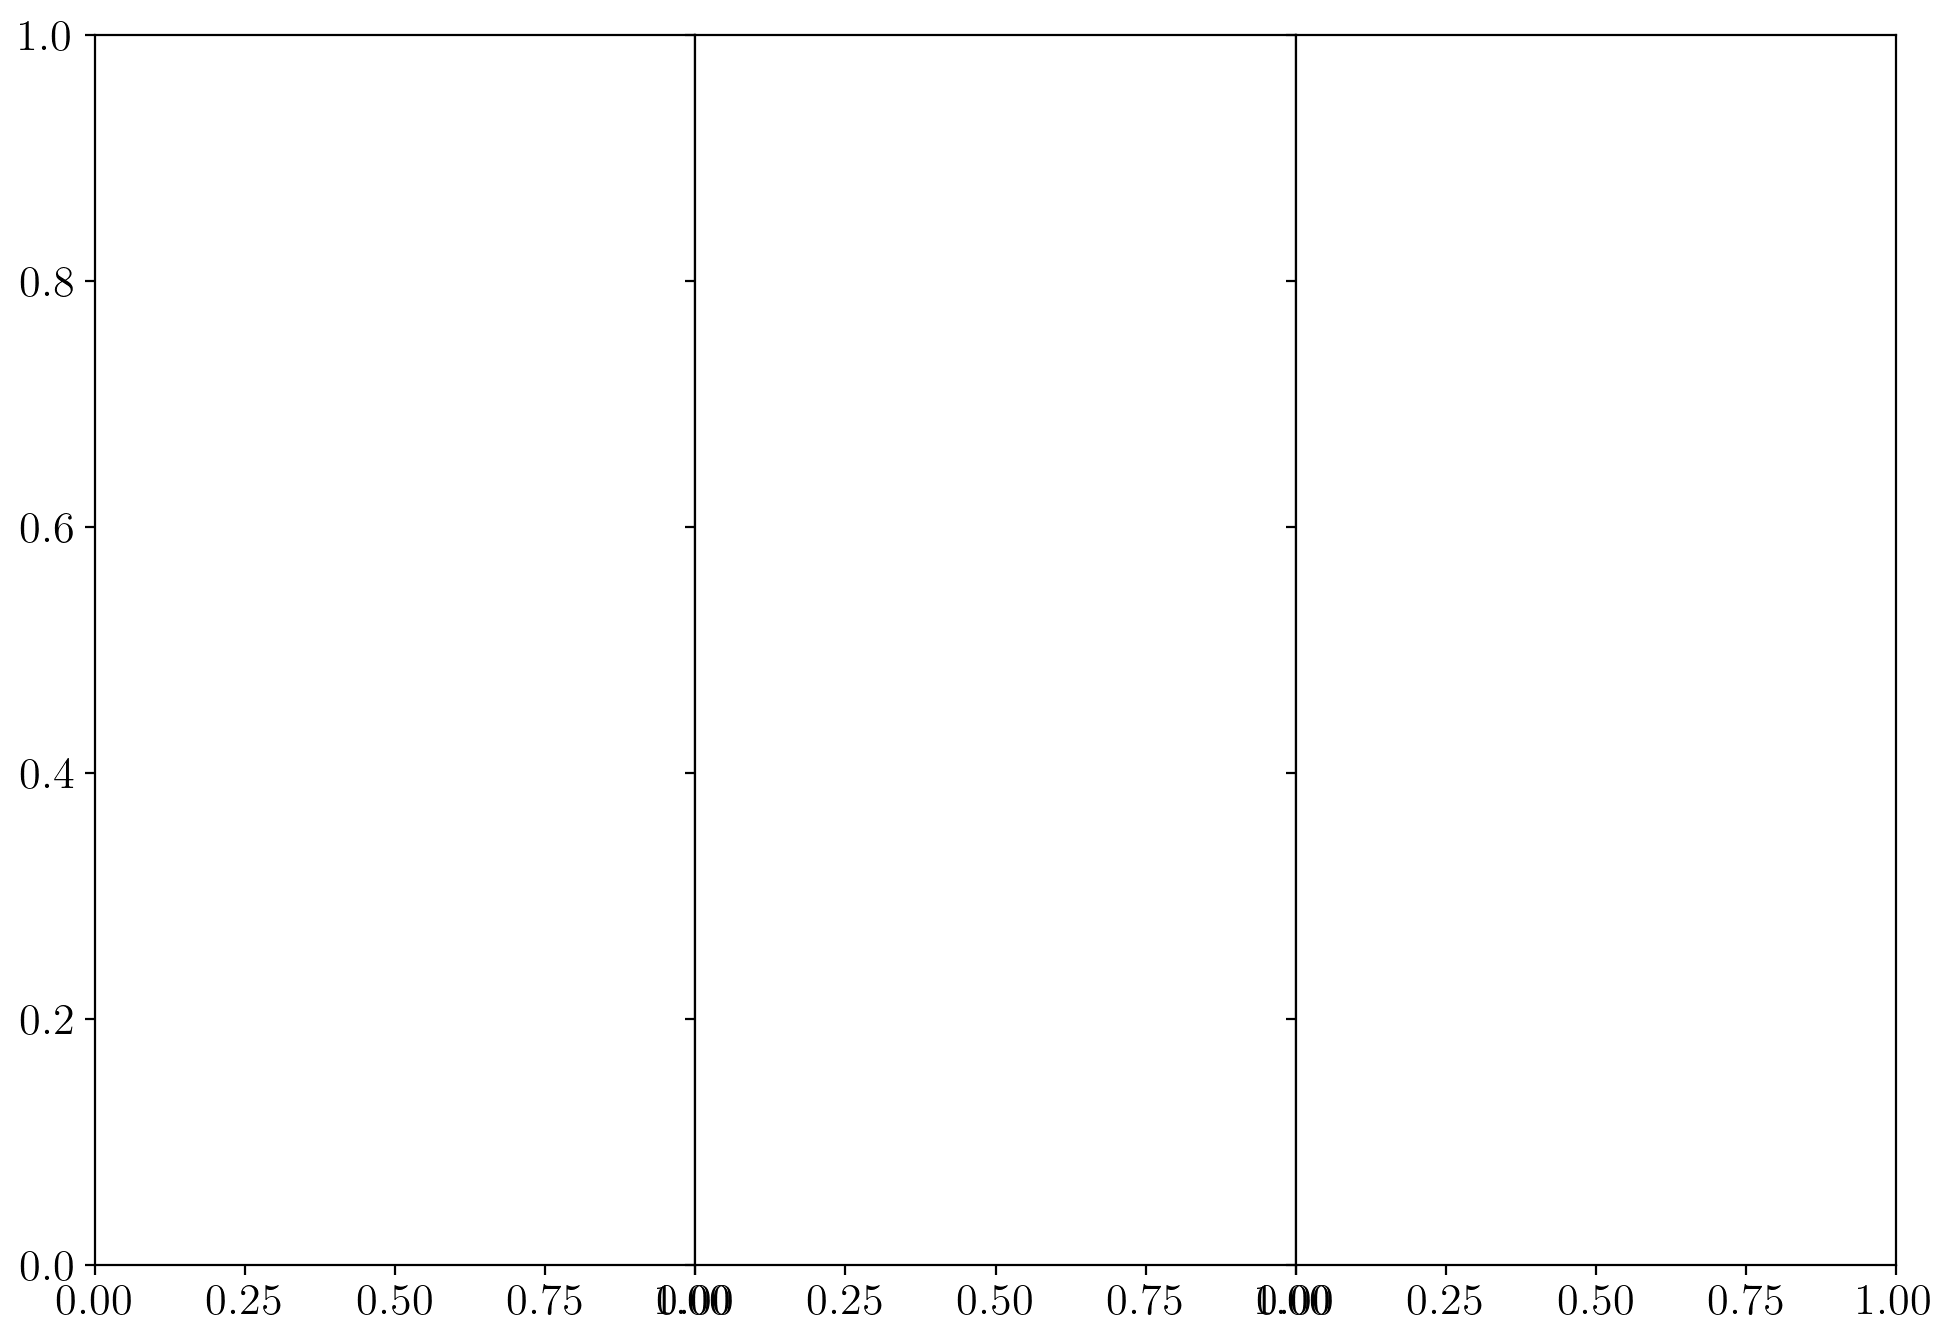

In [7]:
fig, axs = plt.subplots(1, 3, sharey='row',gridspec_kw={'wspace': 0}, dpi=200)

plt.sca(axs[0])

for i in range(len(Kpath_ntc_8_0_c_ref_QP_ntc)):
    plt.plot(Kpath_ntc_8_0_c_ref_QP_ntc[i], E_ntc_8_0_c_ref_QP_ntc[i], 'r-', linewidth=4)

for i in range(len(Kpath_ntc_8_0_QP_ref)):
    plt.plot(Kpath_ntc_8_0_QP_ref[i], E_ntc_8_0_QP_ref[i], 'k--', linewidth=4)

for i in range(len(q_8_0)):
    plt.plot(q_8_0[i], E_q_8_0[i], 'b-', linewidth=4)

plt.xticks([0.0, 1.0], [r'$\Gamma$', r'$\mathrm{M}$'], fontsize=26)
plt.ylabel(r'$E(\mathrm{eV})$', fontsize=26)

plt.sca(axs[1])

for i in range(len(Kpath_ntc_10_0_c_ref_QP_ntc)):
    plt.plot(Kpath_ntc_10_0_c_ref_QP_ntc[i], E_ntc_10_0_c_ref_QP_ntc[i], 'r-', linewidth=4)

for i in range(len(Kpath_ntc_10_0_QP_ref)):
    plt.plot(Kpath_ntc_10_0_QP_ref[i], E_ntc_10_0_QP_ref[i], 'k--', linewidth=4)

for i in range(len(q_10_0)):
    plt.plot(q_10_0[i], E_q_10_0[i], 'b-', linewidth=4)

plt.xticks([0.0, 1.0], [r'$\Gamma$', r'$\mathrm{M}$'], fontsize=26)

plt.sca(axs[2])

for i in range(len(Kpath_ntc_11_0_c_ref_QP_ntc)):
    plt.plot(Kpath_ntc_11_0_c_ref_QP_ntc[i], E_ntc_11_0_c_ref_QP_ntc[i], 'r-', linewidth=4)

for i in range(len(Kpath_ntc_11_0_QP_ref)):
    plt.plot(Kpath_ntc_11_0_QP_ref[i], E_ntc_11_0_QP_ref[i], 'k--', linewidth=4)

for i in range(len(q_10_0)):
    plt.plot(q_11_0[i], E_q_11_0[i], 'b-', linewidth=4)

plt.xticks([0.0, 1.0], [r'$\Gamma$', r'$\mathrm{M}$'], fontsize=26)

plt.ylim([-2.8,4.24])
plt.ylim([-6,6.5])


# Análise ntc(10,0) com defeito

In [5]:
def escreve_TB_params(E0C, E0H, tCC, sCC, tHC):
    arq_out = open('tight_binding_params', 'w')
    
    arq_out.write('\n'+
'\n'+                 
'# Especies atomicas \n'+
'A 1 6 6.1\n'+
'\n'+
'# Energias on site \n'+
'E0 1   '+str(E0H)+' \n'+
'E0 6   0\n'+            
'E0 6.1   '+str(E0C)+' \n'+      
'\n'+
'# Overlap  \n'+
'S 1 1     0.0 \n'+
'S 6 6     '+str(sCC)+' \n'+
'S 6.1 6.1     '+str(sCC)+' \n'+                  
'\n'+
'# Hopping intra  \n'+
't0 1 1  0 0 0 0 \n'+
't0 1 6  '+str(tHC)+' 0 0 0 \n'+
't0 1 6.1  '+str(tHC)+' 0 0 0 \n'+                  
't0 6 6  '+str(tCC)+' 0 0 0 \n'+
't0 6 6.1  '+str(tCC)+' 0 0 0 \n'+                  
't0 6.1 6.1  '+str(tCC)+' 0 0 0 \n'+                  
'\n'+
'# Hopping inter \n'+
't1 6 6      0 0.0 0.0 \n'+
't1 1  6.1  0 0 0 \n'+
't1 6.1  1  0 0 0 \n')
    
    arq_out.close()

def escreve_TB_params2(tCC, sCC):
    arq_out = open('tight_binding_params', 'w')
    
    arq_out.write('\n'+
'\n'+                 
'# Especies atomicas \n'+
'A 6\n'+
'\n'+
'# Energias on site \n'+
'E0 6   0\n'+                  
'\n'+
'# Overlap  \n'+
'S 6 6     '+str(sCC)+' \n'+
'\n'+
'# Hopping intra  \n'+
't0 6 6  '+str(tCC)+' 0 0 0 \n'+
'\n'+
'# Hopping inter \n'+
't1 6 6      -0.3 0.0 0.0 \n')
    
    arq_out.close()

def run_TB():
    #os.system('python tight_binding.py cell_ntc_10_0 tight_binding_params')
    os.system('python tight_binding.py')
    
def angulo_polar(x0, y0, x, y):
    theta = np.arctan2(y-y0, x-x0)
    return(theta) 
    
def replica_cell(INPUT, OUTPUT, Ncells, Natoms_H):

    arq_in = open(INPUT)
    arq_out = open(OUTPUT, 'w')
    
    atomic_pos = []
    a1, a2, a3 = [], [], []
    
    for line in arq_in:
        linha = line.split()
        if len(linha) == 4:
            if linha[0] == 'a1':
                a1 = line
            if linha[0] == 'a2':
                a2 = line
            if linha[0] == 'a3':
                Lz = float(linha[3])
                a3 = 'a3  0.0   0.0   '+str(Ncells*Lz)+'\n'
        if len(linha) == 5:
            atomic_pos.append(linha[0:])
            
    # Fitando circulo
    X, Y = [], []
    for i in range(len(atomic_pos)):
        X.append( float(atomic_pos[i][2]) )
        Y.append( float(atomic_pos[i][3]) )
        
    x0, y0 = np.mean(X), np.mean(Y)
    
    Distances = np.sqrt( (np.array(X) - x0)**2 + (np.array(Y) - y0)**2 )
    R = np.mean(Distances)
    
    print('Centro do ntc: x0='+str(x0)+'  y0='+str(y0))
    print('Raio do ntc: R='+str(R))
                    
    Tot_atoms_C = len(atomic_pos)*Ncells
    C_atoms_bind_to_H = []
    
    while len(C_atoms_bind_to_H) < Natoms_H:
        indC = np.random.randint(Tot_atoms_C)
        if C_atoms_bind_to_H.count(indC) == 0:
            C_atoms_bind_to_H.append(indC)
            
    arq_out.write(a1)
    arq_out.write(a2)
    arq_out.write(a3)
    arq_out.write('\n')
    
    for i in range(Ncells):
        for j in range(len(atomic_pos)):
            
            ind_mol, ind_atom  = int(atomic_pos[j][0]), float(atomic_pos[j][1]) 
            x, y, z = float(atomic_pos[j][2]), float(atomic_pos[j][3]), float(atomic_pos[j][4])
            
            indC = len(atomic_pos)*i + j
            if C_atoms_bind_to_H.count(indC) == 1:

                ind_atom = 6.1
                
                angulo = angulo_polar(x0, y0, x, y)  # angulo_polar(x0, y0, x, y)
                xH, yH = (R+1.0)*np.cos(angulo), (R+1.0)*np.sin(angulo)
                arq_out.write( str(2) + '   ' +str(1) + '  ' + str(xH + x0) + '  ' +str(yH + y0) + '  ' + str( z + i*Lz ) +'\n')

            arq_out.write( str(ind_mol) + '   ' +str(ind_atom) + '  ' + str(x) + '  ' +str(y) + '  ' + str( z + i*Lz ) +'\n')
    
    arq_out.close()
    
def analise_energias_gamma(E_q):
    E_gamma = []
    for i in range(len(E_q)):
        E_gamma.append(E_q[i][0])
    return E_gamma

In [9]:


Egap_10_0 = []
tCC = np.arange(0.1, 5, 0.8)

for t in tCC:

    escreve_TB_params(-t, 0.0)

    run_TB()

    q, E_q = Get_dispersao_TB('Dispersao_cell_ntc_10_0.out')

    temp = analise_energias_gamma(E_q)
    Egap_10_0.append(temp[A.index(0.0) + 1])


plt.figure()

plt.plot(tCC, Egap_10_0)

GapGW_10_0 = 1.64376

z = np.polyfit(tCC, Egap_10_0, 1)
print(z)

t_10_0_GW = GapGW_10_0/z[0]
print(t_10_0_GW)



escreve_TB_params(-t_10_0_GW, 0.0)
run_TB()

q_10_0, E_q_10_0 = Get_dispersao_TB('Dispersao_cell_ntc_10_0.out')


TypeError: escreve_TB_params() missing 3 required positional arguments: 'tCC', 'sCC', and 'tHC'

In [6]:


Egap_11_0 = []
tCC = np.arange(0.1, 7, 0.8)

for t in tCC:

    escreve_TB_params(-t, 0.0)

    run_TB()

    q, E_q = Get_dispersao_TB('Dispersao_cell_ntc_11_0.out')

    temp = analise_energias_gamma(E_q)
    egap = temp[temp.index(0.0) + 1]
    Egap_11_0.append(egap)


plt.figure()

plt.plot(tCC, Egap_11_0)

GapGW_11_0 = 2.036583376034077

z = np.polyfit(tCC, Egap_11_0, 1)
print(z)

t_11_0_GW = GapGW_11_0/z[0]
print(t_11_0_GW)


escreve_TB_params(-t_11_0_GW, 0.0)
run_TB()

q_11_0, E_q_11_0 = Get_dispersao_TB('Dispersao_cell_ntc_11_0.out')


TypeError: escreve_TB_params() missing 3 required positional arguments: 'tCC', 'sCC', and 'tHC'

ValueError: x and y must have same first dimension, but have shapes (1,) and (9,)

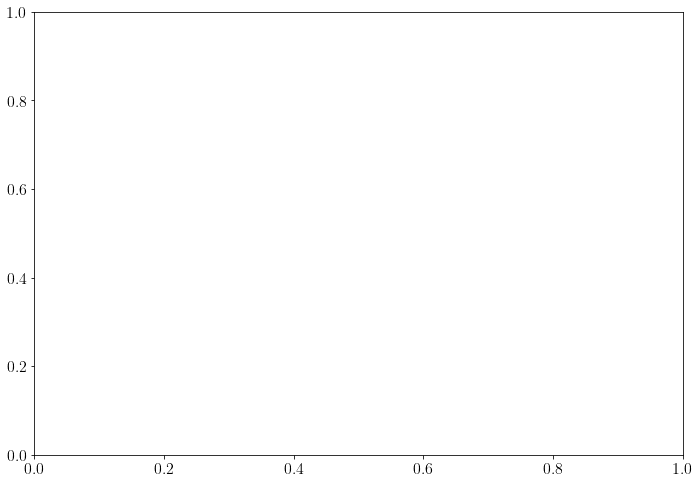

In [11]:


Egap_8_0 = []
tCC = np.arange(0.1, 7, 0.8)

for t in tCC:


    E0C, E0H, tCC, sCC, tHC = 0, 0, 1, 0, 0.5
    escreve_TB_params(E0C, E0H, tCC, sCC, tHC)

    run_TB()

    q, E_q = Get_dispersao_TB('Dispersao_cell_ntc_10_0.out')

    temp = analise_energias_gamma(E_q)
    egap = temp[temp.index(0.0) + 1]
    Egap_8_0.append(egap)


plt.figure()

plt.plot(tCC, Egap_8_0)

GapGW_8_0 = 2.25928

z = np.polyfit(tCC, Egap_8_0, 1)
print(z)

t_8_0_GW = GapGW_8_0/z[0]
print(t_8_0_GW)


escreve_TB_params(-t_8_0_GW, 0.0)
run_TB()

q_8_0, E_q_8_0 = Get_dispersao_TB('Dispersao_cell_ntc_8_0.out')


In [ ]:
egap

# Dependência dos splits e nível de impureza 

In [7]:
# Dados DFT

split_c1_over_gap_q0_DFT = [0.14938942, 0.11832218, 0.09276514, 0.07400275]
split_v1_over_gap_q0_DFT = [0.26458616, 0.18855035, 0.14373801, 0.11458047]
imp_level_over_gap_q0_DFT = [0.3990502,  0.41549392, 0.41847081, 0.41980743]

split_c1_over_gap_q1_DFT = [0.12547517, 0.09751915, 0.07921785, 0.06823203]
split_v1_over_gap_q1_DFT = [0.32164789, 0.24800852, 0.19302349, 0.15264756]
imp_level_over_gap_q1_DFT = [0.28001577, 0.26662153, 0.24141553, 0.21396289]

split_c1_over_gap_qn1_DFT = [0.19069597, 0.15818154, 0.12763451, 0.10227503]
split_v1_over_gap_qn1_DFT = [0.21335292, 0.152227, 0.12068572, 0.10480392]
imp_level_over_gap_qn1_DFT = [0.54883381, 0.59415735, 0.63454262, 0.67592523]


(-0.5, 0.5)

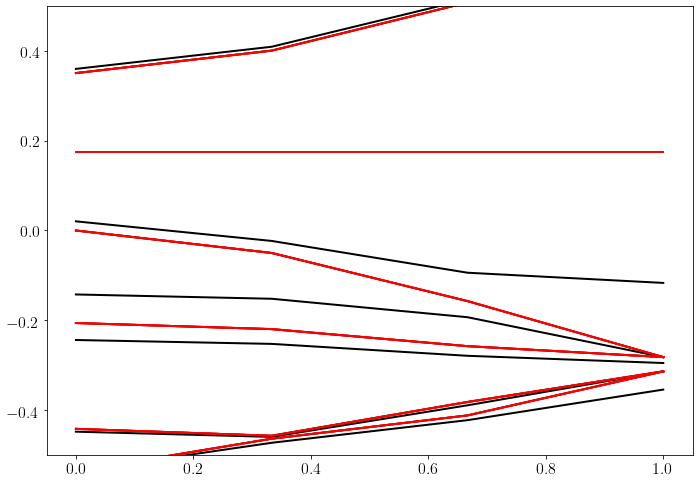

In [8]:
def escreve_inputTB(PREFIX, banda_val, Nkpoints):

    arq_in = open('input_TB', 'w')

    arq_in.write("PREFIX = "+PREFIX+"\n"+
                 "UNITS = ANGSTROM\n"+
                 "PARAMS_TB = tight_binding_params\n"+
                 "NKpoints = "+str(Nkpoints)+"\n"+
                 "NPROCS = 1\n"+
                 "VERBOSITY = False\n"+
                 "PLOT = True\n"+
                 "VAL_BANDS_PLOT = 0\n"+
                 "COND_BANDS_PLOT = 0\n"+
                 "BANDA_VAL_INDEX = "+str(banda_val)+"\n"+
                 "OPTICAL_ABSORPTION = False\n"+
                 "EMIN_VAL_BAND = 2.0\n"+
                 "EMIN_COND_BAND = 3.0\n"+
                 "BROADENING_ABS = 4e-2\n"+
                 "EVALUATE_DOS = False\n"+
                 "EVALUATE_LDOS = False\n"+
                 "CURVATURE = False\n"+
                 "WRITE_EIGVECS = False")

    arq_in.close()


def escreve_TB_params(E0C, E0H, tCC, sCC, tHC):
    arq_out = open('tight_binding_params', 'w')
    
    arq_out.write('\n'+
'\n'+                 
'# Especies atomicas \n'+
'A 1 6 6.1\n'+
'\n'+
'# Energias on site \n'+
'E0 1   '+str(E0H)+' \n'+
'E0 6   0\n'+            
'E0 6.1   '+str(E0C)+' \n'+      
'\n'+
'# Overlap  \n'+
'S 1 1     0.0 \n'+
'S 6 6     '+str(sCC)+' \n'+
'S 6.1 6.1     '+str(sCC)+' \n'+                  
'\n'+
'# Hopping intra  \n'+
't0 1 1  0 0 0 0 \n'+
't0 6 6  '+str(tCC)+' 0 0 0 \n'+
't0 6 6.1  '+str(tCC)+' 0 0 0 \n'+                  
't0 6.1 6.1  '+str(tCC)+' 0 0 0 \n'+                  
'\n'+
'# Hopping inter \n'+
't1 6 6      0 0.0 0.0 \n'+
't1 1  6.1  '+str(tHC)+' 0 0 \n')
    
    arq_out.close()


t_10_0_GW = 1

banda_val = 80
PREFIX = 'cell_ntcH_10_0_4cells'
escreve_inputTB(PREFIX, banda_val, 3)
E0H = -0.4
E0C = -E0H
tHC= -0.5
escreve_TB_params(E0C, E0H, -1, 0, tHC)  # (E0C, E0H, tCC, sCC, tHC)
run_TB()

q, E_q = Get_dispersao_TB('Dispersao_'+PREFIX+'.out')

plt.figure()

for i in range(len(q)):
    plt.plot(q[i], E_q[i], 'k-')

E0H = -0.00
E0C = -E0H
tHC= 0
escreve_TB_params(E0C, E0H, -1, 0, tHC)
run_TB()

q, E_q = Get_dispersao_TB('Dispersao_'+PREFIX+'.out')

for i in range(len(q)):
    plt.plot(q[i], E_q[i], 'r-')

plt.ylim([-0.5, 0.5])


In [9]:
temp = analise_energias_gamma(E_q)
val_band_index = temp.index(0.0)
egap = temp[val_band_index + 2]
imp_level = temp[val_band_index + 1]
split_cond = temp[val_band_index + 3] - temp[val_band_index + 2]
split_val = -temp[val_band_index - 1]

print(egap, imp_level, split_cond, split_val)

0.3511410091698911 0.17557050458494403 1.1102230246251565e-15 8.049116928532385e-16


In [10]:
#plt.figure(figsize=(3, 8))

xplot, yplot = [], []
SPLITS_VAL, SPLITS_COND, IMP_LEVEL = [], [], []
#t_HC = np.linspace(0.01, 1.0, 10,  endpoint=True)
#E0H = np.linspace(-0.1, 0.0, 5, endpoint=True)
t_HC = np.linspace(0.01, 1.0, 30,  endpoint=True)
E0H = np.linspace(-0.6, 0.6, 20, endpoint=True)
#E0H = np.linspace(-0.1, 0.0, 5, endpoint=True)

banda_vals = [80, 120, 160, 200]
PREFIXS = ['cell_ntcH_10_0_4cells', 'cell_ntcH_10_0_6cells', 'cell_ntcH_10_0_8cells', 'cell_ntcH_10_0_10cells']

# testes
#t_HC = np.linspace(0.01, 1.0, 2,  endpoint=True)
#E0H = np.linspace(-0.2, 0.2, 4, endpoint=True)

banda_vals = [80]
PREFIXS = ['cell_ntcH_10_0_4cells']



for i in range(len(t_HC)):
    for j in range(len(E0H)):    
        xplot.append(t_HC[i])
        yplot.append(E0H[j])


#banda_vals = [80] #, 120]
#PREFIXS = ['cell_ntcH_10_0_4cells'] #, 'cell_ntcH_10_0_6cells']

for p in range(len(PREFIXS)):
    PREFIX, banda_val = PREFIXS[p], banda_vals[p]
    escreve_inputTB(PREFIX, banda_val, 3)

    SPLITS_VAL.append([])
    SPLITS_COND.append([])
    IMP_LEVEL.append([])

    for i in range(len(t_HC)):
        for j in range(len(E0H)):

            print('Running case', t_HC[i], E0H[j])

            # escreve_TB_pararms(E0C, E0H, tCC, sCC, tHC)
            escreve_TB_params(0.0, E0H[j]*t_10_0_GW, -t_10_0_GW, 0, -t_HC[i]*t_10_0_GW)

            run_TB()

            q, E_q = Get_dispersao_TB('Dispersao_'+PREFIX+'.out')

            temp = analise_energias_gamma(E_q)
            val_band_index = temp.index(0.0)

            egap = temp[val_band_index + 2]
            imp_level = temp[val_band_index + 1]
            split_cond = temp[val_band_index + 3] - temp[val_band_index + 2]
            split_val = -temp[val_band_index - 1]

            SPLITS_VAL[-1].append(split_val/egap)
            SPLITS_COND[-1].append(split_cond/egap)
            IMP_LEVEL[-1].append(imp_level/egap)


Running case 0.01 -0.6
Running case 0.01 -0.5368421052631579
Running case 0.01 -0.47368421052631576
Running case 0.01 -0.41052631578947363
Running case 0.01 -0.34736842105263155
Running case 0.01 -0.28421052631578947
Running case 0.01 -0.22105263157894733
Running case 0.01 -0.1578947368421052
Running case 0.01 -0.09473684210526312
Running case 0.01 -0.03157894736842104
Running case 0.01 0.03157894736842104
Running case 0.01 0.09473684210526323
Running case 0.01 0.1578947368421053
Running case 0.01 0.2210526315789474
Running case 0.01 0.2842105263157896
Running case 0.01 0.34736842105263166
Running case 0.01 0.41052631578947374
Running case 0.01 0.4736842105263158
Running case 0.01 0.5368421052631579
Running case 0.01 0.6
Running case 0.04413793103448276 -0.6
Running case 0.04413793103448276 -0.5368421052631579
Running case 0.04413793103448276 -0.47368421052631576
Running case 0.04413793103448276 -0.41052631578947363
Running case 0.04413793103448276 -0.34736842105263155
Running case 0.0

Running case 0.2831034482758621 -0.22105263157894733
Running case 0.2831034482758621 -0.1578947368421052
Running case 0.2831034482758621 -0.09473684210526312
Running case 0.2831034482758621 -0.03157894736842104
Running case 0.2831034482758621 0.03157894736842104
Running case 0.2831034482758621 0.09473684210526323
Running case 0.2831034482758621 0.1578947368421053
Running case 0.2831034482758621 0.2210526315789474
Running case 0.2831034482758621 0.2842105263157896
Running case 0.2831034482758621 0.34736842105263166
Running case 0.2831034482758621 0.41052631578947374
Running case 0.2831034482758621 0.4736842105263158
Running case 0.2831034482758621 0.5368421052631579
Running case 0.2831034482758621 0.6
Running case 0.31724137931034485 -0.6
Running case 0.31724137931034485 -0.5368421052631579
Running case 0.31724137931034485 -0.47368421052631576
Running case 0.31724137931034485 -0.41052631578947363
Running case 0.31724137931034485 -0.34736842105263155
Running case 0.31724137931034485 -0.2

Running case 0.5562068965517242 -0.1578947368421052
Running case 0.5562068965517242 -0.09473684210526312
Running case 0.5562068965517242 -0.03157894736842104
Running case 0.5562068965517242 0.03157894736842104
Running case 0.5562068965517242 0.09473684210526323
Running case 0.5562068965517242 0.1578947368421053
Running case 0.5562068965517242 0.2210526315789474
Running case 0.5562068965517242 0.2842105263157896
Running case 0.5562068965517242 0.34736842105263166
Running case 0.5562068965517242 0.41052631578947374
Running case 0.5562068965517242 0.4736842105263158
Running case 0.5562068965517242 0.5368421052631579
Running case 0.5562068965517242 0.6
Running case 0.5903448275862069 -0.6
Running case 0.5903448275862069 -0.5368421052631579
Running case 0.5903448275862069 -0.47368421052631576
Running case 0.5903448275862069 -0.41052631578947363
Running case 0.5903448275862069 -0.34736842105263155
Running case 0.5903448275862069 -0.28421052631578947
Running case 0.5903448275862069 -0.2210526

Running case 0.8293103448275863 -0.03157894736842104
Running case 0.8293103448275863 0.03157894736842104
Running case 0.8293103448275863 0.09473684210526323
Running case 0.8293103448275863 0.1578947368421053
Running case 0.8293103448275863 0.2210526315789474
Running case 0.8293103448275863 0.2842105263157896
Running case 0.8293103448275863 0.34736842105263166
Running case 0.8293103448275863 0.41052631578947374
Running case 0.8293103448275863 0.4736842105263158
Running case 0.8293103448275863 0.5368421052631579
Running case 0.8293103448275863 0.6
Running case 0.863448275862069 -0.6
Running case 0.863448275862069 -0.5368421052631579
Running case 0.863448275862069 -0.47368421052631576
Running case 0.863448275862069 -0.41052631578947363
Running case 0.863448275862069 -0.34736842105263155
Running case 0.863448275862069 -0.28421052631578947
Running case 0.863448275862069 -0.22105263157894733
Running case 0.863448275862069 -0.1578947368421052
Running case 0.863448275862069 -0.0947368421052631

600


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


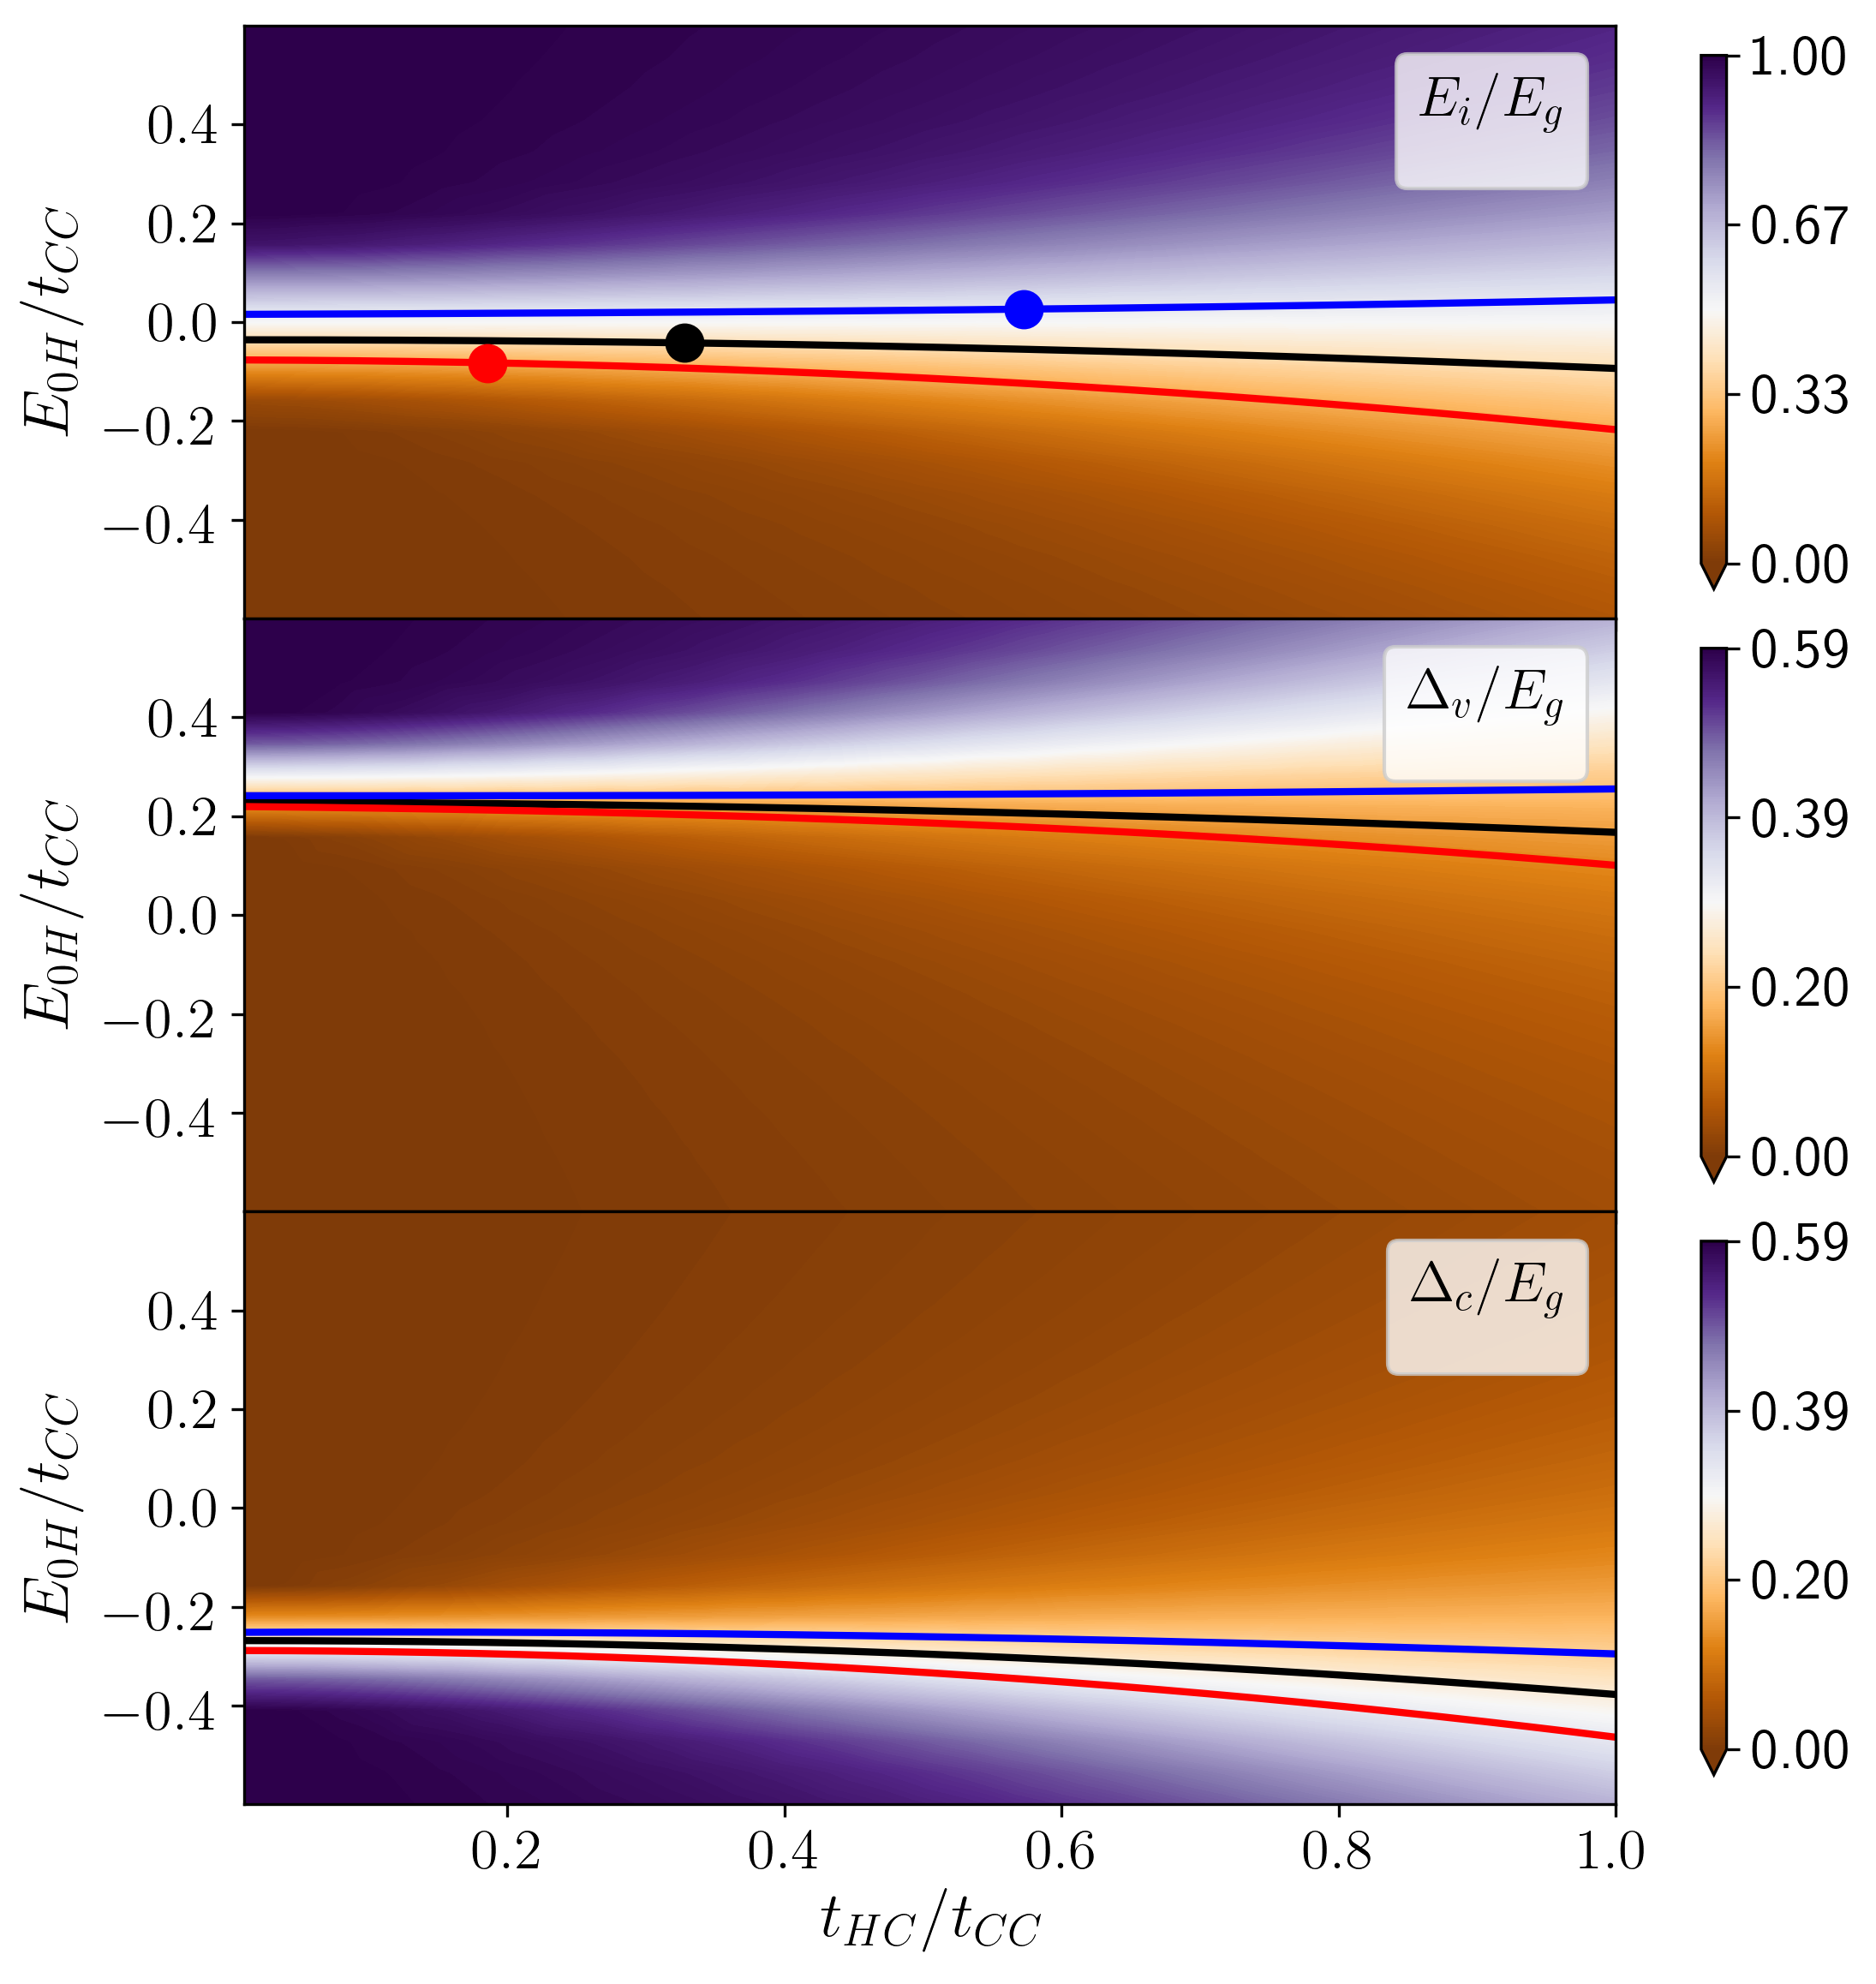

In [14]:

Npoints = 300
min_diff = 1e-2

t_q0, E0_q0 = 0.32785953177257526, -0.04214046822742479
t_q1, E0_q1 = 0.1854849498327759, -0.08227424749163881
t_qn1, E0_qn1 = 0.572876254180602, 0.02608695652173909

print(len(xplot))
xplot, yplot = np.array(xplot), np.array(yplot)
#f, axs = plt.subplots(3, len(PREFIXS), sharex=True, sharey=True , gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(14.0, 14.0), dpi=300)

f, axs = plt.subplots(3, 1, sharex=True, sharey=True , gridspec_kw={'hspace': 0.0, 'wspace': 0}, figsize=(8.0, 8.0), dpi=300)

for i in range(1): #len(PREFIXS)):

    split_val, split_cond, Imp_level = np.array(SPLITS_VAL[i]), np.array(SPLITS_COND[i]), np.array(IMP_LEVEL[i])

    xi = np.linspace(xplot.min(), xplot.max(), Npoints)
    yi = np.linspace(yplot.min(), yplot.max(), Npoints)

    #plt.sca(axs[0][i])
    plt.sca(axs[0])

    zi = scipy.interpolate.griddata((xplot, yplot), Imp_level, (xi[None,:], yi[:,None]), method='linear')

    #fig.suptitle('Impurity Level', fontsize=18)
    #plt.contourf(xi, yi, zi, levels=500, alpha=1.0, 
    #             cmap='Reds', vmin=0, vmax=0.5) #cmap='RdBu_r')
    # plt.colorbar()
    levels = np.linspace(0.0, max(Imp_level), 200)
    plt.contourf(xi, yi, zi, levels=levels, alpha=1.0, 
                 cmap='PuOr', extend='min') #cmap='RdBu_r')
    #cmap='RdBu_r')
    #cbar = f.colorbar(axs[0])

    #plt.xlabel(r'$ t_{HC}/t_{CC} $')
    plt.xticks()
    if i == 0:
        plt.ylabel(r'$ E_{0H}/t_{CC} $')


    alvo = imp_level_over_gap_q0_DFT[i]
    alvo2 = imp_level_over_gap_q1_DFT[i]
    alvo3 = imp_level_over_gap_qn1_DFT[i]
    menor_diff = min(abs(Imp_level - alvo))
    x_menores_diffs, y_menores_diffs = [], []
    x_menores_diffs2, y_menores_diffs2 = [], []
    x_menores_diffs3, y_menores_diffs3 = [], []

    tempx, tempy = [], []

    for j in range(len(xi)):
        for k in range(len(yi)):
            if abs(zi[k][j] - alvo) <= min_diff:
                x_menores_diffs.append(xi[j]) 
                y_menores_diffs.append(yi[k])
                tempx.append(xi[j]) 
                tempy.append(yi[k])
            if abs(zi[k][j] - alvo2) <= min_diff:
                x_menores_diffs2.append(xi[j]) 
                y_menores_diffs2.append(yi[k])
            if abs(zi[k][j] - alvo3) <= min_diff:
                x_menores_diffs3.append(xi[j]) 
                y_menores_diffs3.append(yi[k])
    #plt.plot(x_menores_diffs, y_menores_diffs, 'bo', markersize = 1.0)

    fit = np.polyfit(x_menores_diffs, y_menores_diffs, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'k-')#, label='q= 0')
             #label=r'$E_i / E_g = $'+str(round(alvo, 3)))

    fit = np.polyfit(x_menores_diffs2, y_menores_diffs2, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'r-')#, label='q= +1')
             #label=r'$E_i / E_g = $'+str(round(alvo2, 3)))

    fit = np.polyfit(x_menores_diffs3, y_menores_diffs3, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'b-')#, label='q= -1')
             #label=r'$E_i / E_g = $'+str(round(alvo3, 3)))
    
    plt.plot([t_q0], [E0_q0], 'ko')
    plt.plot([t_q1], [E0_q1], 'ro')
    plt.plot([t_qn1], [E0_qn1], 'bo')

    plt.legend()

    #plt.sca(axs[1][i])
    plt.sca(axs[1])

    zi = scipy.interpolate.griddata((xplot, yplot), split_cond, (xi[None,:], yi[:,None]), method='linear')

    #fig.suptitle('Impurity Level', fontsize=18)
    levels = np.linspace(0.0, max(split_cond), 200)
    plt.contourf(xi, yi, zi, levels=levels, alpha=1.0, 
                 cmap='PuOr', extend='min') #cmap='RdBu_r')
    # plt.colorbar()
    #cbar = f.colorbar(axs[1])

    #plt.xlabel(r'$ t_{HC}/t_{CC} $')
    plt.xticks()
    if i == 0:
        plt.ylabel(r'$ E_{0H}/t_{CC} $')
    

    alvo = split_c1_over_gap_q0_DFT[i]
    alvo2 = split_c1_over_gap_q1_DFT[i]
    alvo3 = split_c1_over_gap_qn1_DFT[i]

    x_menores_diffs, y_menores_diffs = [], []
    x_menores_diffs2, y_menores_diffs2 = [], []
    x_menores_diffs3, y_menores_diffs3 = [], []

    

    for j in range(len(xi)):
        for k in range(len(yi)):
            if abs(zi[k][j] - alvo) <= min_diff:
                x_menores_diffs.append(xi[j]) 
                y_menores_diffs.append(yi[k])
            if abs(zi[k][j] - alvo2) <= min_diff:
                x_menores_diffs2.append(xi[j]) 
                y_menores_diffs2.append(yi[k])
            if abs(zi[k][j] - alvo3) <= min_diff:
                x_menores_diffs3.append(xi[j]) 
                y_menores_diffs3.append(yi[k])
            
    #plt.plot(x_menores_diffs, y_menores_diffs, 'ko', markersize = 1.0)
    fit = np.polyfit(x_menores_diffs, y_menores_diffs, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'k-')#, label='q=0')
             #label=r'$ \Delta_c / E_g = $'+str(round(alvo, 3)))

    fit = np.polyfit(x_menores_diffs2, y_menores_diffs2, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'r-')#, label='q=1')
             #label=r'$ \Delta_c / E_g = $'+str(round(alvo2, 3)))

    fit = np.polyfit(x_menores_diffs3, y_menores_diffs3, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'b-')#, label='q=-1')
             #label=r'$ \Delta_c / E_g = $'+str(round(alvo3, 3)))
            
    plt.legend()


    #plt.sca(axs[2][i])
    plt.sca(axs[2])

    zi = scipy.interpolate.griddata((xplot, yplot), split_val, (xi[None,:], yi[:,None]), method='linear')

    #fig.suptitle('Impurity Level', fontsize=18)
    levels = np.linspace(0.0, max(split_val), 200)
    plt.contourf(xi, yi, zi, levels=levels, alpha=1.0, 
                 cmap='PuOr', extend='min') #cmap='RdBu_r')

    # plt.colorbar()
    #cbar = f.colorbar(axs[2])

    plt.xlabel(r'$ t_{HC}/t_{CC} $')
    if i == 0:
        plt.ylabel(r'$ E_{0H}/t_{CC} $')

    alvo = split_v1_over_gap_q0_DFT[i]
    alvo2 = split_v1_over_gap_q1_DFT[i]
    alvo3 = split_v1_over_gap_qn1_DFT[i]

    x_menores_diffs, y_menores_diffs = [], []
    x_menores_diffs2, y_menores_diffs2 = [], []
    x_menores_diffs3, y_menores_diffs3 = [], []

    for j in range(len(xi)):
        for k in range(len(yi)):
            if abs(zi[k][j] - alvo) <= min_diff:
                x_menores_diffs.append(xi[j]) 
                y_menores_diffs.append(yi[k])
            if abs(zi[k][j] - alvo2) <= min_diff:
                x_menores_diffs2.append(xi[j]) 
                y_menores_diffs2.append(yi[k])
            if abs(zi[k][j] - alvo3) <= min_diff:
                x_menores_diffs3.append(xi[j]) 
                y_menores_diffs3.append(yi[k])
            
    #plt.plot(x_menores_diffs, y_menores_diffs, 'bo', markersize = 1.0)
    fit = np.polyfit(x_menores_diffs, y_menores_diffs, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'k-')#, label='q= 0')
             #label=r'$ \Delta_v / E_g = $'+str(round(alvo, 3)))

    fit = np.polyfit(x_menores_diffs2, y_menores_diffs2, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'r-')#, label='q= +1')
             #label=r'$ \Delta_v / E_g = $'+str(round(alvo2, 3)))

    fit = np.polyfit(x_menores_diffs3, y_menores_diffs3, 3)
    plt.plot(xi, np.poly1d(fit)(xi), 'b-')#, label='q= -1')
             #label=r'$ \Delta_v / E_g = $'+str(round(alvo3, 3)))
       

    plt.legend()

    #plt.ylim([-0.2,0.2])
    plt.ylim([-0.6, 0.6])
    plt.sca(axs[0])
    #plt.colorbar(boundaries=np.linspace(-0.01, 0.61, 4), shrink=0.9, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.colorbar(shrink=0.9, ticks=np.linspace(0, max(Imp_level), 4), format='%.2f')#,  label=r'$(\mathrm{eV})$')
    plt.yticks([-0.4, -0.2, 0, 0.2, 0.4])
    plt.legend(title=r'$E_i / E_g$')
    #boundaries=np.linspace(0, 2, 6)
    plt.sca(axs[1])
    plt.yticks([-0.4, -0.2, 0, 0.2, 0.4])
    plt.legend(title=r'$\Delta_v / E_g $')
    #plt.colorbar(boundaries=np.linspace(-0.01, 0.61, 4), shrink=0.9, ticks=[0.0, 0.2, 0.4, 0.6])
    plt.colorbar(shrink=0.9, ticks=np.linspace(0, max(split_cond), 4), format='%.2f')#,  label=r'$(\mathrm{eV})$')
    plt.sca(axs[2])
    plt.legend(title=r'$\Delta_c / E_g $')
    plt.yticks([-0.4, -0.2, 0, 0.2, 0.4])
    #plt.colorbar(boundaries=np.linspace(-0.01, 0.61, 4), shrink=0.9, ticks=[0.0, 0.2, 0.4, 0.6])
    plt.colorbar(shrink=0.9, ticks=np.linspace(0, max(split_val), 4), format='%.2f')#, label=r'$(\mathrm{eV})$')

#f.colorbar(pcm, ax=axs[0, :], location='right')#, shrink=0.6)

plt.savefig('splits_imp_level_funcao_params_TB.png')

DFT q=0
139 96 1.1045032678735911e-05
1.1045032678735911e-05 0.3990502
0.32785953177257526
-0.04214046822742479
DFT q=1
129 53 1.5427170160786652e-06
1.5427170160786652e-06 0.28001577
0.1854849498327759
-0.08227424749163881
DFT q=-1
156 170 5.90331241578923e-06
5.90331241578923e-06 0.54883381
0.572876254180602
0.02608695652173909


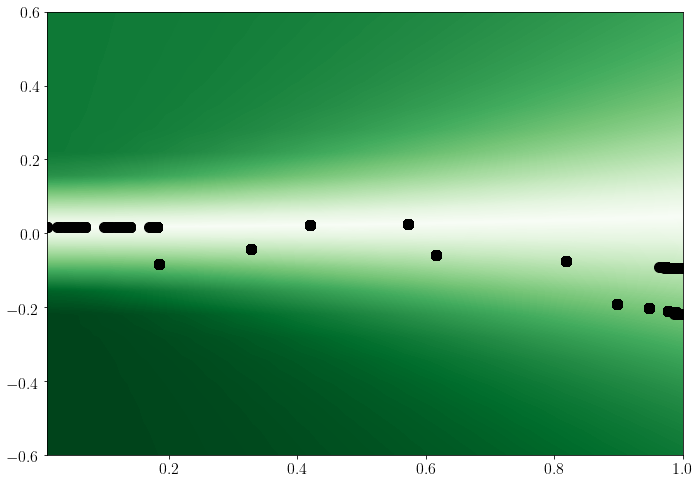

In [13]:
plt.figure()

alvo = imp_level_over_gap_q0_DFT[0]

zi = abs( scipy.interpolate.griddata((xplot, yplot), Imp_level, (xi[None,:], yi[:,None]), method='linear') - alvo )

menor_diff = 1e-2
cutoff_diff = 5e-3

for i in range(len(zi)):
    for j in range(len(zi[i])):
        if zi[i][j] < menor_diff:
            i_menor_diff, j_menor_diff = i, j
            menor_diff = zi[i][j]
        if zi[i][j] < cutoff_diff:
            plt.plot(xi[j_menor_diff], yi[i_menor_diff], 'ko')

print('DFT q=0')
print(i_menor_diff, j_menor_diff, menor_diff)
print(zi[i_menor_diff][j_menor_diff], alvo)
print(xi[j_menor_diff])
print(yi[i_menor_diff])

alvo = imp_level_over_gap_q1_DFT[0]

zi = abs( scipy.interpolate.griddata((xplot, yplot), Imp_level, (xi[None,:], yi[:,None]), method='linear') - alvo )

menor_diff = 1e-2
cutoff_diff = 5e-3

for i in range(len(zi)):
    for j in range(len(zi[i])):
        if zi[i][j] < menor_diff:
            i_menor_diff, j_menor_diff = i, j
            menor_diff = zi[i][j]
        if zi[i][j] < cutoff_diff:
            plt.plot(xi[j_menor_diff], yi[i_menor_diff], 'ko')

print('DFT q=1')
print(i_menor_diff, j_menor_diff, menor_diff)
print(zi[i_menor_diff][j_menor_diff], alvo)
print(xi[j_menor_diff])
print(yi[i_menor_diff])

alvo = imp_level_over_gap_qn1_DFT[0]

zi = abs( scipy.interpolate.griddata((xplot, yplot), Imp_level, (xi[None,:], yi[:,None]), method='linear') - alvo )

menor_diff = 1e-2
cutoff_diff = 5e-3

for i in range(len(zi)):
    for j in range(len(zi[i])):
        if zi[i][j] < menor_diff:
            i_menor_diff, j_menor_diff = i, j
            menor_diff = zi[i][j]
        if zi[i][j] < cutoff_diff:
            plt.plot(xi[j_menor_diff], yi[i_menor_diff], 'ko')

print('DFT q=-1')
print(i_menor_diff, j_menor_diff, menor_diff)
print(zi[i_menor_diff][j_menor_diff], alvo)
print(xi[j_menor_diff])
print(yi[i_menor_diff])

plt.contourf(xi, yi, zi, levels=200, alpha=1.0, 
                 cmap='Greens', extend='min')

Melhores parâmetros para reproduzir nível de impureza DFT q=0: tHC = 0.6126086956521739

E0H = -0.058193979933110374 = -E0C

In [ ]:
# replica_cell(INPUT, OUTPUT, Ncells, Natoms_H)

replica_cell('cell_ntc_10_0.xyz', 'cell_ntcH_10_0_4cells.xyz', 4, 1)

# Estudos de espectro de absorção


In [ ]:
def escreve_inputTB(PREFIX, banda_val, Nkpoints):

    arq_in = open('input_TB', 'w')

    arq_in.write("PREFIX = "+PREFIX+"\n"+
                 "UNITS = ANGSTROM\n"+
                 "PARAMS_TB = tight_binding_params\n"+
                 "NKpoints = "+str(Nkpoints)+"\n"+
                 "NPROCS = 1\n"+
                 "VERBOSITY = False\n"+
                 "PLOT = True\n"+
                 "VAL_BANDS_PLOT = 0\n"+
                 "COND_BANDS_PLOT = 0\n"+
                 "BANDA_VAL_INDEX = "+str(banda_val)+"\n"+
                 "OPTICAL_ABSORPTION = True\n"+
                 "EMIN_VAL_BAND = 2.0\n"+
                 "EMIN_COND_BAND = 3.0\n"+
                 "BROADENING_ABS = 4e-2\n"+
                 "EVALUATE_DOS = True\n"+
                 "EVALUATE_LDOS = False\n"+
                 "CURVATURE = False\n"+
                 "WRITE_EIGVECS = False")

    arq_in.close()


def escreve_TB_params(E0C, E0H, tCC, sCC, tHC):
    arq_out = open('tight_binding_params', 'w')
    
    arq_out.write('\n'+
'\n'+                 
'# Especies atomicas \n'+
'A 1 6 6.1\n'+
'\n'+
'# Energias on site \n'+
'E0 1   '+str(E0H)+' \n'+
'E0 6   0\n'+            
'E0 6.1   '+str(E0C)+' \n'+      
'\n'+
'# Overlap  \n'+
'S 1 1     0.0 \n'+
'S 6 6     '+str(sCC)+' \n'+
'S 6.1 6.1     '+str(sCC)+' \n'+                  
'\n'+
'# Hopping intra  \n'+
't0 1 1  0 0 0 0 \n'+
't0 6 6  '+str(tCC)+' 0 0 0 \n'+
't0 6 6.1  '+str(tCC)+' 0 0 0 \n'+                  
't0 6.1 6.1  '+str(tCC)+' 0 0 0 \n'+                  
'\n'+
'# Hopping inter \n'+
't1 6 6      0 0.0 0.0 \n'+
't1 1  6.1  '+str(tHC)+' 0 0 \n')
    
    arq_out.close()

def replica_cell_random(INPUT, OUTPUT, Ncells, Natoms_H):

    arq_in = open(INPUT)
    arq_out = open(OUTPUT, 'w')
    
    atomic_pos = []
    a1, a2, a3 = [], [], []
    
    for line in arq_in:
        linha = line.split()
        if len(linha) == 4:
            if linha[0] == 'a1':
                a1 = line
            if linha[0] == 'a2':
                a2 = line
            if linha[0] == 'a3':
                Lz = float(linha[3])
                a3 = 'a3  0.0   0.0   '+str(Ncells*Lz)+'\n'
        if len(linha) == 5:
            atomic_pos.append(linha[0:])
            
    # Fitando circulo
    X, Y = [], []
    for i in range(len(atomic_pos)):
        X.append( float(atomic_pos[i][2]) )
        Y.append( float(atomic_pos[i][3]) )
        
    x0, y0 = np.mean(X), np.mean(Y)
    
    Distances = np.sqrt( (np.array(X) - x0)**2 + (np.array(Y) - y0)**2 )
    R = np.mean(Distances)
    
    print('Centro do ntc: x0='+str(x0)+'  y0='+str(y0))
    print('Raio do ntc: R='+str(R))
                    
    Tot_atoms_C = len(atomic_pos)*Ncells
    C_atoms_bind_to_H = []
    
    while len(C_atoms_bind_to_H) < Natoms_H:
        indC = np.random.randint(Tot_atoms_C)
        if C_atoms_bind_to_H.count(indC) == 0:
            C_atoms_bind_to_H.append(indC)
            
    arq_out.write(a1)
    arq_out.write(a2)
    arq_out.write(a3)
    arq_out.write('\n')
    
    for i in range(Ncells):
        for j in range(len(atomic_pos)):
            
            ind_mol, ind_atom  = int(atomic_pos[j][0]), float(atomic_pos[j][1]) 
            x, y, z = float(atomic_pos[j][2]), float(atomic_pos[j][3]), float(atomic_pos[j][4])
            
            indC = len(atomic_pos)*i + j
            if C_atoms_bind_to_H.count(indC) == 1:

                ind_atom = 6.1
                
                angulo = angulo_polar(x0, y0, x, y)  # angulo_polar(x0, y0, x, y)
                xH, yH = (R+1.0)*np.cos(angulo), (R+1.0)*np.sin(angulo)
                arq_out.write( str(2) + '   ' +str(1) + '  ' + str(xH + x0) + '  ' +str(yH + y0) + '  ' + str( z + i*Lz ) +'\n')

            arq_out.write( str(ind_mol) + '   ' +str(ind_atom) + '  ' + str(x) + '  ' +str(y) + '  ' + str( z + i*Lz ) +'\n')
    
    arq_out.close()

def replica_cell(INPUT, OUTPUT, Ncells, Natoms_H):

    arq_in = open(INPUT)
    arq_out = open(OUTPUT, 'w')
    
    atomic_pos = []
    a1, a2, a3 = [], [], []
    
    for line in arq_in:
        linha = line.split()
        if len(linha) == 4:
            if linha[0] == 'a1':
                a1 = line
            if linha[0] == 'a2':
                a2 = line
            if linha[0] == 'a3':
                Lz = float(linha[3])
                a3 = 'a3  0.0   0.0   '+str(Ncells*Lz)+'\n'
        if len(linha) == 5:
            atomic_pos.append(linha[0:])
            
    # Fitando circulo
    X, Y = [], []
    for i in range(len(atomic_pos)):
        X.append( float(atomic_pos[i][2]) )
        Y.append( float(atomic_pos[i][3]) )
        
    x0, y0 = np.mean(X), np.mean(Y)
    
    Distances = np.sqrt( (np.array(X) - x0)**2 + (np.array(Y) - y0)**2 )
    R = np.mean(Distances)
    
    print('Centro do ntc: x0='+str(x0)+'  y0='+str(y0))
    print('Raio do ntc: R='+str(R))
                    
    Tot_atoms_C = len(atomic_pos)*Ncells
    C_atoms_bind_to_H = []
    
    while len(C_atoms_bind_to_H) < Natoms_H:
        indC = np.random.randint(Tot_atoms_C)
        if C_atoms_bind_to_H.count(indC) == 0:
            C_atoms_bind_to_H.append(indC)
            
    arq_out.write(a1)
    arq_out.write(a2)
    arq_out.write(a3)
    arq_out.write('\n')
    
    for i in range(Ncells):
        for j in range(len(atomic_pos)):
            
            ind_mol, ind_atom  = int(atomic_pos[j][0]), float(atomic_pos[j][1]) 
            x, y, z = float(atomic_pos[j][2]), float(atomic_pos[j][3]), float(atomic_pos[j][4])
            
            indC = len(atomic_pos)*i + j
            if C_atoms_bind_to_H.count(indC) == 1:

                ind_atom = 6.1
                
                angulo = angulo_polar(x0, y0, x, y)  # angulo_polar(x0, y0, x, y)
                xH, yH = (R+1.0)*np.cos(angulo), (R+1.0)*np.sin(angulo)
                arq_out.write( str(2) + '   ' +str(1) + '  ' + str(xH + x0) + '  ' +str(yH + y0) + '  ' + str( z + i*Lz ) +'\n')

            arq_out.write( str(ind_mol) + '   ' +str(ind_atom) + '  ' + str(x) + '  ' +str(y) + '  ' + str( z + i*Lz ) +'\n')
    
    arq_out.close()

def read_DOS_file(file):

    Edos, dos = [], []
    arq = open(file)

    for line in arq:
        linha = line.split()
        Edos.append(float(linha[0]))
        dos.append(float(linha[1]))

    return Edos, dos

def read_abs_file(file):

    Eabs, absorption = [], []
    arq = open(file)

    for line in arq:
        linha = line.split()
        Eabs.append(float(linha[0]))
        absorption.append(float(linha[1]))

    return Eabs, absorption

In [ ]:
#replica_cell('cell_ntc_10_0.xyz', 'cell_ntcH_10_0_2cells.xyz', 2, 1)

t_HC = 0.6126086956521739
E_0H = -0.058193979933110374 
E_0C = -E_0H
t_10_0_GW = 4.681

escreve_TB_params(-E_0H*t_10_0_GW, E_0H*t_10_0_GW, -t_10_0_GW, 0.0, -t_HC*t_10_0_GW)


PREFIX = 'cell_ntcH_10_0_4cells'
escreve_inputTB(PREFIX, 80, 50)

run_TB()
q, E_q = Get_dispersao_TB('Dispersao_'+PREFIX+'.out')

PREFIX = 'cell_ntc_10_0'
escreve_inputTB(PREFIX, 20, 200)

run_TB()
q_pure, E_q_pure = Get_dispersao_TB('Dispersao_'+PREFIX+'.out')

In [ ]:
plt.figure()

for i in range(len(q)):
    plt.plot(q[i], E_q[i], 'r-')

for i in range(len(q_pure)):
    plt.plot(np.array(q_pure[i])*4, E_q_pure[i], 'k-')

plt.ylim([-2, 3])
plt.xlim([0, 1])

In [ ]:
plt.figure()

Edos_pure, Dos_pure = read_DOS_file('cell_ntc_10_0_DOS.out')
Edos_cntH, Dos_cntH = read_DOS_file('cell_ntcH_10_0_4cells_DOS.out')

plt.plot(Edos_pure, np.array(Dos_pure)/max(Dos_pure), 'k-')
plt.plot(Edos_cntH, np.array(Dos_cntH)/max(Dos_cntH), 'r-')

#plt.xlim([-5, 5.5])

In [ ]:
plt.figure()

Eabs_pure, Abs_pure = read_abs_file('cell_ntc_10_0_absorption_tot.out')
Eabs_cntH, Abs_cntH = read_abs_file('cell_ntcH_10_0_4cells_absorption_tot.out')

Eabs_pure, Abs_pure = np.array(Eabs_pure), np.array(Abs_pure)
Eabs_cntH, Abs_cntH = np.array(Eabs_cntH), np.array(Abs_cntH)

plt.plot(Eabs_pure, Abs_pure/max(Abs_pure[0:200]), 'k-')
plt.plot(Eabs_cntH, Abs_cntH/max(Abs_cntH[0:200]), 'r-')

In [15]:
Ncells = 60  # total de átomos de carbono é 40*Ncells - 80*40 = 3200

NHatoms = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 600]
#NHatoms = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200]
Nsamples = 100

for i in range(len(NHatoms)):
    for j in range(20, Nsamples):
        replica_cell('cell_ntc_10_0.xyz', 'absorption_diff_concentrations/q0/'+str(Ncells)+'cells/'+str(NHatoms[i])+'/cell_ntcH_10_0_'+str(NHatoms[i])+'_atoms_'+str(Ncells)+'cells_sample_'+str(j)+'.xyz', Ncells, NHatoms[i])


Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y

Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y

Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y

Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y

Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y

Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y

Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y0=20.0
Raio do ntc: R=3.919861422156631
Centro do ntc: x0=20.0  y

(12, 14.5)

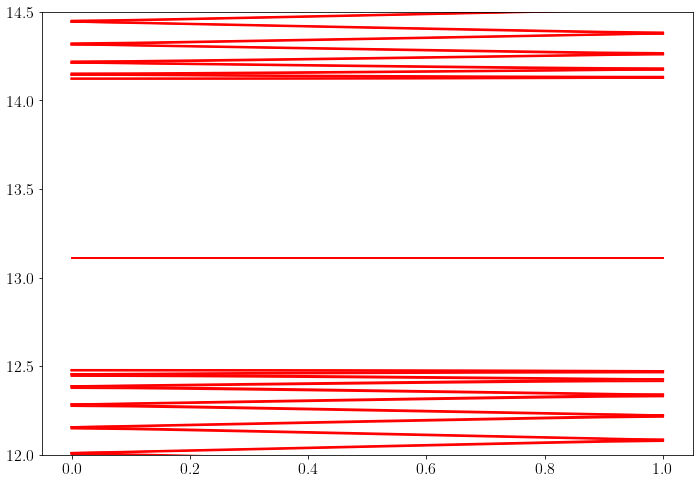

In [8]:
file = '/home/rafael/Dropbox/Research/Tight_binding/absorption_diff_concentrations/1/Dispersao_cell_ntcH_10_0_1_atoms_80cells_sample_0.out'


plt.figure()

q, E_q = Get_dispersao_TB(file)

for i in range(len(q)):
    plt.plot(q[i], E_q[i], 'r-')

plt.ylim([12, 14.5])